# Beyond Genre: Discovering Listening Modes from Spotify Audio Features



#### This project explores whether music listening behavior is better explained by audio features rather than genre labels. Using Spotify-style audio features, I analyze how tracks cluster into interpretable listening modes that reflect context, mood, and activity. The goal is to understand whether audio-feature-based groupings offer a more flexible representation of listening intent.

---

In [11]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [15]:
# Set the path to the file you'd like to load
file_path = "dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "maharshipandya/-spotify-tracks-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8c/jcvkgfv50g3415k7r1kbhpcc0000gn/T/ipykernel_69306/1929904415.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [16]:
df.shape
df.columns
df.dtypes
df.head(3)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


In [17]:
core_cols = [
    "track_id", "track_name", "artists",
    "popularity", "duration_ms", "explicit",
    "danceability", "energy", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo",
    "track_genre"
]

df = df[core_cols].copy()


In [22]:
df.isna().sum().sort_values(ascending=False).head(15)
df.duplicated().sum()
df["track_genre"].nunique()
df["track_genre"].value_counts().head(20)

track_genre
acoustic       1000
emo            1000
rock-n-roll    1000
reggaeton      1000
disco          1000
r-n-b          1000
punk-rock      1000
pagode         1000
electronic     1000
mpb            1000
country        1000
metalcore      1000
mandopop       1000
funk           1000
garage         1000
j-rock         1000
industrial     1000
indie-pop      1000
rock           1000
reggae         1000
Name: count, dtype: int64

- Each genre has exactly 1000 tracks

- There are 125 genres total

- This dataset is intentionally balanced

In [23]:
top_genres = df["track_genre"].value_counts().head(20).index
df_top = df[df["track_genre"].isin(top_genres)].copy()

In [24]:
df_top["track_genre"].nunique()

20

In [25]:
features = [
    "energy",
    "valence",
    "tempo",
    "danceability",
    "acousticness",
    "instrumentalness",
    "speechiness"
]


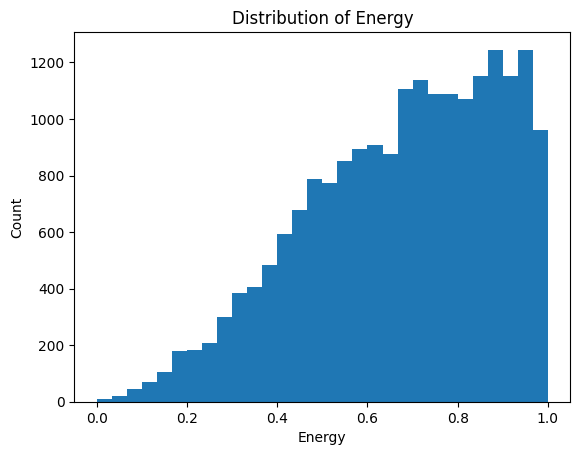

In [26]:
import matplotlib.pyplot as plt

plt.hist(df_top["energy"], bins=30)
plt.title("Distribution of Energy")
plt.xlabel("Energy")
plt.ylabel("Count")
plt.show()
#left skewed

#### the dataset skews toward moderate-to-high energy tracks. This reflects a catalog bias toward engaging, energetic music, which may influence recommendation systems if not explicitly corrected for context. This further motivates the need to distinguish listening modes rather than relying on global averages.

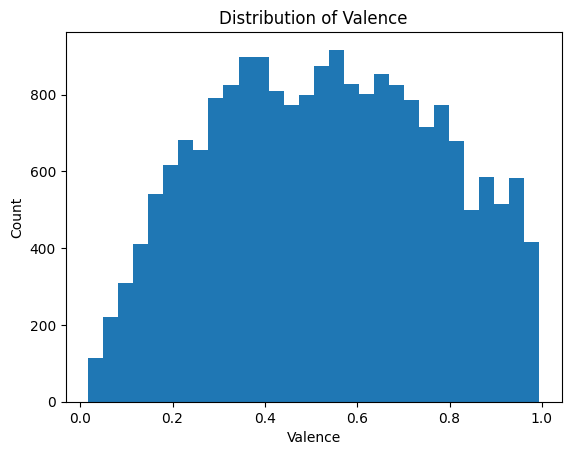

In [27]:
plt.hist(df_top["valence"], bins=30)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Count")
plt.show()
# wide

#### Valence is broadly distributed across the full range, indicating a wide spectrum of emotional tone in the dataset. This suggests that emotional positivity is not genre-specific and that most genres contain both positive and negative emotional expressions. Valence is therefore better suited for identifying emotional listening modes rather than classifying genres directly.

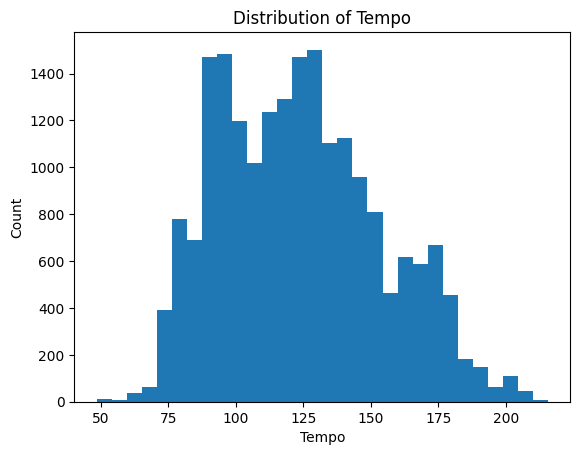

In [28]:
plt.hist(df_top["tempo"], bins=30)
plt.title("Distribution of Tempo")
plt.xlabel("Tempo")
plt.ylabel("Count")
plt.show()
# appr normal /right skewed

#### Tempo shows a wide and multi-modal distribution, indicating the presence of multiple rhythmic regimes within the dataset. This suggests that tempo may play a key role in separating listening experiences such as slow, relaxed tracks versus fast, high-momentum tracks. Unlike energy, tempo variation appears across many genres, reinforcing the idea that rhythm-based listening modes may cut across genre boundaries.

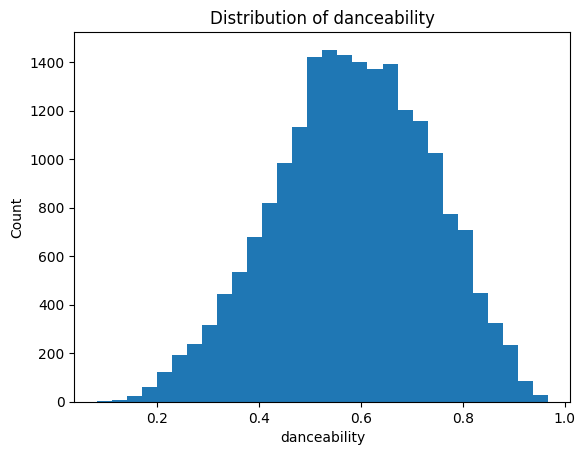

In [29]:
plt.hist(df_top["danceability"], bins=30)
plt.title("Distribution of danceability")
plt.xlabel("danceability")
plt.ylabel("Count")
plt.show()
#left skewed

#### Danceability follows a roughly unimodal distribution, with most tracks falling in a moderate-to-high range. This suggests that across genres, Spotify’s catalog tends to favor rhythmic accessibility rather than extremes. As a result, danceability alone is unlikely to distinguish genres, but may still help separate listening modes when combined with other features.

# Do genres actually differ?

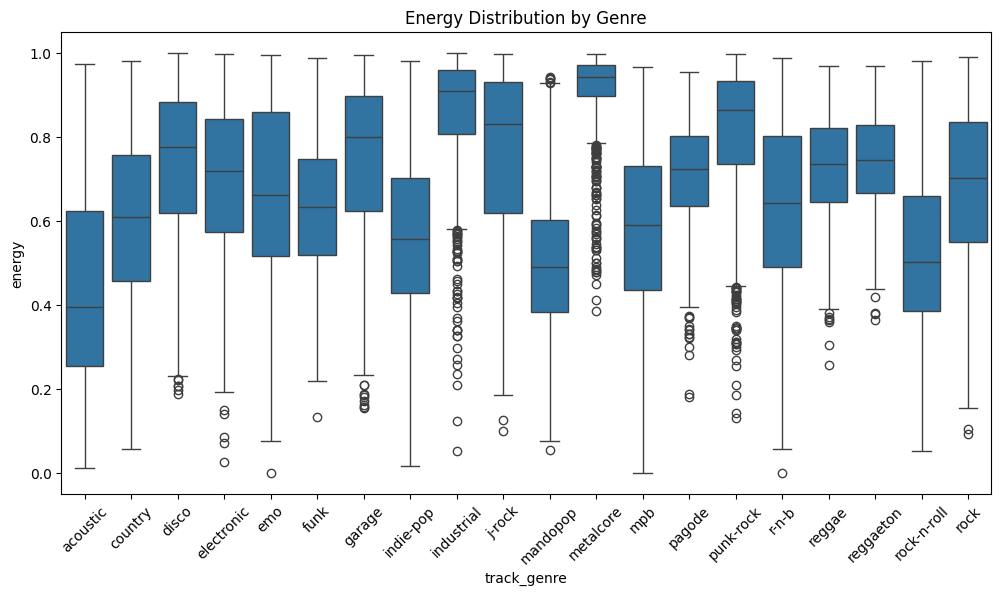

In [30]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_top,
    x="track_genre",
    y="energy"
)
plt.xticks(rotation=45)
plt.title("Energy Distribution by Genre")
plt.show()


#### Energy differs strongly across genres, but consistency takes different forms. High-energy genres such as metalcore, punk-rock, and industrial exhibit high median energy and relatively tight central distributions, indicating a strong and consistent core sound. However, these genres also contain numerous low-energy outliers, suggesting occasional deviations from their dominant intensity profile rather than broad internal diversity. In contrast, genres like electronic and indie-pop show wider energy distributions overall, reflecting genuine variability across tracks rather than isolated exceptions. This distinction highlights that genre labels capture dominant tendencies but not the full range of listening intent.

In [31]:
import pandas as pd

# compute mean audio features per genre
genre_means = (
    df_top
    .groupby("track_genre")[features]
    .mean()
)

genre_means.head()


,energy,valence,tempo,danceability,acousticness,instrumentalness,speechiness
track_genre,,,,,,,
acoustic,0.435368,0.424023,119.010624,0.549593,0.566816,0.038336,0.043247
country,0.596805,0.521481,123.963307,0.555294,0.321227,0.005585,0.042268
disco,0.737565,0.670754,121.974380,0.676692,0.166213,0.080952,0.059252
electronic,0.694752,0.391839,122.947839,0.652945,0.177026,0.248697,0.081768
emo,0.669967,0.441135,126.992643,0.599321,0.195081,0.030281,0.108957


In [32]:
# normalize 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
genre_means_scaled = pd.DataFrame(
    scaler.fit_transform(genre_means),
    index=genre_means.index,
    columns=genre_means.columns
)

genre_means_scaled.head()


,energy,valence,tempo,danceability,acousticness,instrumentalness,speechiness
track_genre,,,,,,,
acoustic,-2.044690,-0.963895,-1.211102,-0.417452,1.754438,-0.170530,-1.106809
country,-0.672509,-0.077246,0.015541,-0.348461,0.283599,-0.634822,-1.139411
disco,0.523918,1.280794,-0.477061,1.120652,-0.644781,0.433610,-0.573820
electronic,0.160020,-1.256697,-0.235962,0.833275,-0.580018,2.811621,0.176020
emo,-0.050651,-0.808214,0.765824,0.184337,-0.471891,-0.284716,1.081488


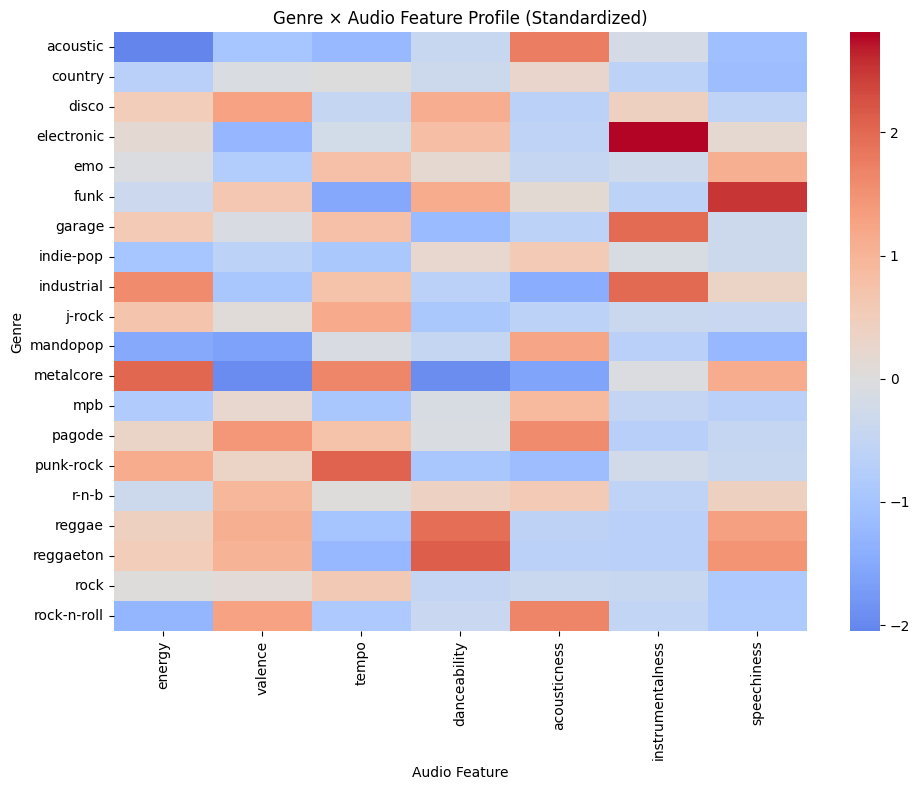

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    genre_means_scaled,
    cmap="coolwarm",
    center=0
)

plt.title("Genre × Audio Feature Profile (Standardized)")
plt.xlabel("Audio Feature")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


## Analysis
### The heatmap reveals clear but overlapping genre-level audio profiles. High-energy genres such as metalcore, punk-rock, and industrial show strong positive deviations in energy and tempo, while acoustic and mandopop are characterized by low energy and high acousticness. Dance-oriented genres like disco, funk, reggaeton, and reggae cluster around higher danceability and valence, indicating shared rhythmic and emotional traits despite different genre labels. In contrast, emotional tone (valence) and speechiness vary widely across genres, suggesting that mood and vocal presence are not tightly bound to genre. Overall, the overlap in feature patterns across genres suggests that listening intent may be better captured by audio-feature-based groupings rather than genre alone.

# Do interpretable “listening modes” emerge when tracks are grouped by audio features rather than genre?

In [34]:
cluster_features = [
    "energy",
    "valence",
    "danceability",
    "acousticness",
    "instrumentalness"
]


In [35]:
X = df_top[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
from sklearn.cluster import KMeans

inertia = []
K = range(3, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

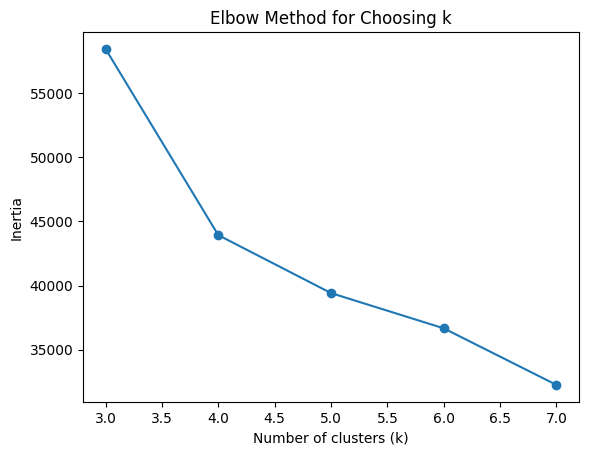

In [37]:
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing k")
plt.show()


In [38]:
# k =4 is the smallest number of clusters that captures meaningful variation

In [39]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)

df_top["cluster"] = kmeans.fit_predict(X_scaled)

In [40]:
cluster_profiles = (
    df_top
    .groupby("cluster")[cluster_features]
    .mean()
)

cluster_profiles


,energy,valence,danceability,acousticness,instrumentalness
cluster,,,,,
0,0.828254,0.418044,0.470546,0.058557,0.018088
1,0.418490,0.390665,0.537108,0.625838,0.010465
2,0.713877,0.385516,0.565974,0.188348,0.722102
3,0.715069,0.722994,0.703290,0.230353,0.008871


#### Clustering tracks by audio features reveals four distinct and interpretable listening modes. These modes correspond to intense high-energy tracks, calm acoustic listening, instrumental focus-oriented music, and upbeat danceable tracks. Importantly, these clusters are defined by combinations of energy, mood, rhythm, and texture rather than genre labels, indicating that listening intent cuts across traditional genre boundaries. This supports the idea that audio features provide a more flexible and context-aware representation of music consumption than genre alone.

### Interpreting the Clusters (Listening Modes)

- **Cluster 0 – High-energy / Intense**  
  Loud, fast, and aggressive tracks with high energy and low acousticness.

- **Cluster 1 – Calm / Acoustic / Relaxed**  
  Softer, more acoustic tracks suited for chill or background listening.

- **Cluster 2 – Instrumental / Focus-oriented**  
  Tracks with high instrumentalness and moderate energy, ideal for focus or work.

- **Cluster 3 – Upbeat / Danceable / Positive**  
  High valence and danceability, reflecting cheerful or social listening contexts.


In [41]:
pd.crosstab(df_top["cluster"], df_top["track_genre"], normalize="index")


track_genre,acoustic,country,disco,electronic,emo,funk,garage,indie-pop,industrial,j-rock,mandopop,metalcore,mpb,pagode,punk-rock,r-n-b,reggae,reggaeton,rock,rock-n-roll
cluster,,,,,,,,,,,,,,,,,,,,
0,0.023876,0.044953,0.017948,0.048576,0.069488,0.017125,0.077062,0.033262,0.104067,0.090565,0.027993,0.154125,0.030133,0.018442,0.105878,0.032109,0.013502,0.011691,0.066853,0.012350
1,0.131435,0.075712,0.025439,0.021401,0.045225,0.044418,0.024632,0.081365,0.003028,0.035938,0.141530,0.002423,0.085605,0.061175,0.012114,0.052090,0.007672,0.005047,0.041591,0.102160
2,0.031657,0.001862,0.085661,0.272812,0.031657,0.005587,0.203911,0.036313,0.204842,0.020484,0.001862,0.039106,0.008380,0.000000,0.029795,0.002793,0.000931,0.000931,0.010242,0.011173
3,0.021519,0.044304,0.085190,0.038734,0.040506,0.084810,0.024177,0.045063,0.016835,0.031646,0.016076,0.001266,0.048608,0.074051,0.033544,0.068861,0.111266,0.114304,0.047722,0.051519


#### Each listening mode contains tracks from multiple genres, reinforcing that genre alone is an incomplete proxy for listening intent.

In [42]:
#PCA is used here strictly for visualization; clustering was performed in the original standardized feature space.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [46]:
import pandas as pd

"""
PC1 primarily captures energy and tempo variation, while PC2 reflects mood and acoustic texture
"""
plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": df_top["cluster"]
})


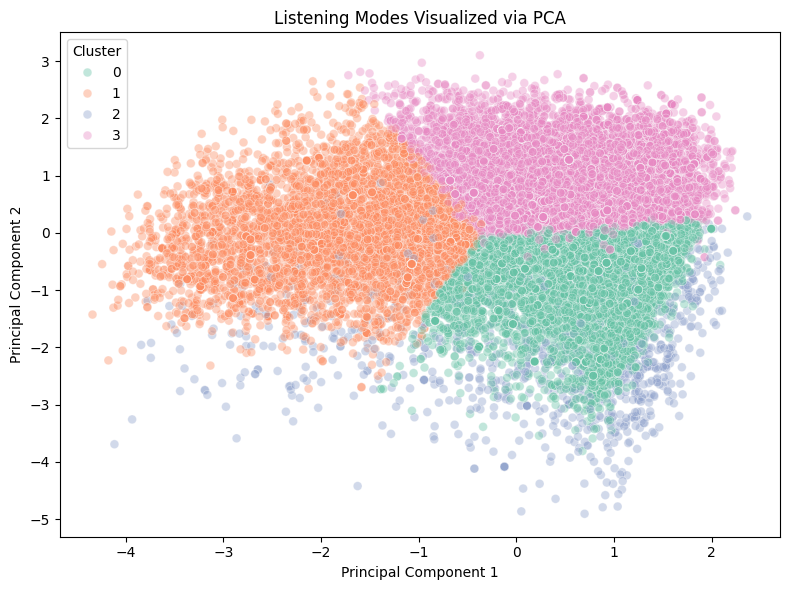

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set2",
    alpha=0.4,
    s=40
)

plt.title("Listening Modes Visualized via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


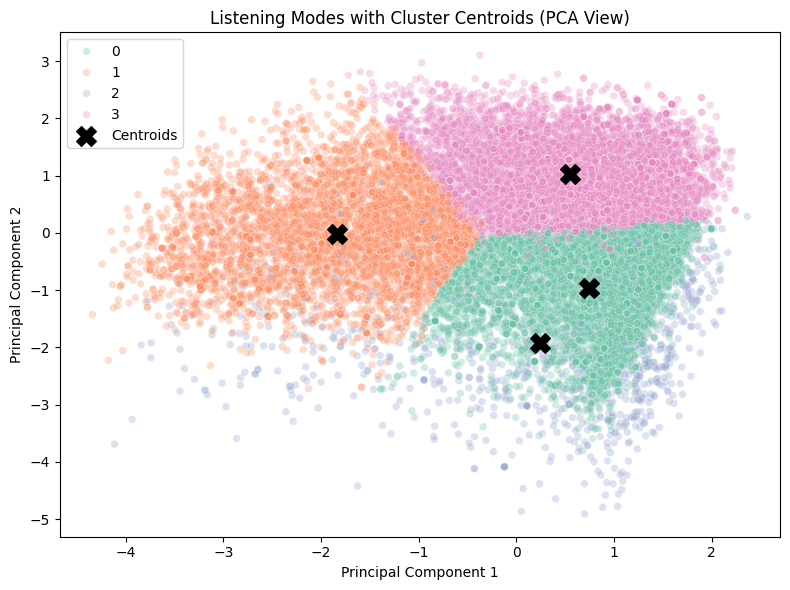

In [45]:
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set2",
    alpha=0.3,
    s=30
)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="black",
    s=200,
    marker="X",
    label="Centroids"
)

plt.title("Listening Modes with Cluster Centroids (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


#### The PCA visualization reveals four coherent listening modes with soft boundaries between them. While each cluster forms a dense region around its centroid, partial overlap reflects gradual transitions between moods and listening contexts rather than rigid categories.This aligns with real-world listening behavior, where users shift smoothly between focus, relaxation, and high-energy modes depending on context.

## Product Implications & Key Insights

### Key Insights
- Tracks cluster into four interpretable listening modes based on audio features rather than genre.
- These modes reflect energy, mood, rhythm, and texture, and cut across traditional genre boundaries.
- Partial overlap between clusters suggests listening behavior exists on a continuum rather than as rigid categories.

### Why This Matters
- Audio-feature-based listening modes enable more context-aware recommendations than genre alone.
- Overlapping clusters support smoother playlist transitions and session-based recommendation strategies.
- Mode-based personalization aligns better with real-world listening contexts such as focus, relaxation, and social settings.
